In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.integrate import odeint
from glob import glob
import pickle
from sklearn.linear_model import LinearRegression
from pathlib import Path
from nufeb_tools import utils,plot
import seaborn as sns


In [2]:
BASE_DIR = Path(f'../simulation-data/axenic-se/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

In [3]:
data = [utils.get_data(directory=str(x)) for x in folders]

Assigning ancestry: 100%|██████████| 100/100 [00:00<00:00, 298.51it/s]


In [4]:
Volume = 1e-4*1e-4*5e-5 #m^3
CellNum2OD = Volume*1e6/0.3e-8
SucroseMW = 342.3
dfs = []
for x in data:
    temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)/SucroseMW*1e3],axis=1)
    temp.columns=['OD750','Hours','Sucrose']
    temp['SucroseExport'] = x.sucRatio/100
    dfs.append(temp)
df = pd.concat(dfs)
df.head()

,OD750,Hours,Sucrose,SucroseExport
0,0.300,0.000000,2.918854e-19,0.0
1,0.300,0.277778,2.918854e-19,0.0
2,0.300,0.555556,2.918854e-19,0.0
3,0.300,0.833333,2.918854e-19,0.0
4,0.312,1.111111,2.918854e-19,0.0


In [5]:
x.ntypes.cyano/CellNum2OD


0      0.300
1      0.300
2      0.300
3      0.300
4      0.306
       ...  
96     1.272
97     1.302
98     1.338
99     1.368
100    1.392
Name: cyano, Length: 101, dtype: float64

In [6]:
x.avg_con.Sucrose.reset_index(drop=True)/SucroseMW*1e3

0      2.918854e-19
1      6.872804e-02
2      1.364392e-01
3      2.052696e-01
4      2.752426e-01
           ...     
96     1.551952e+01
97     1.584446e+01
98     1.617480e+01
99     1.651066e+01
100    1.685209e+01
Name: Sucrose, Length: 101, dtype: float64

In [7]:
x.avg_con/SucroseMW*1e3

,O2,Sucrose,CO2
Hours,,,
0.000000,0.821648,2.918854e-19,1.984782
0.277778,0.822013,6.872804e-02,1.984340
0.555556,0.822019,1.364392e-01,1.984333
0.833333,0.822025,2.052696e-01,1.984326
1.111111,0.822031,2.752426e-01,1.984318
...,...,...,...
26.666667,0.823414,1.551952e+01,1.982644
26.944444,0.823443,1.584446e+01,1.982609
27.222222,0.823473,1.617480e+01,1.982573


In [26]:
ExpPath = f'../experimental-data/Biomass CscB-SPS original strain.xlsx'
Experimental = pd.read_excel(ExpPath,sheet_name='Compiled')
Experimental.loc[:,'Sucrose_mM'] =Experimental.loc[:,'Sucrose']/SucroseMW*1e3
iptg = [0,1e-5,1e-3]
labels = ['0 mM IPTG','10 uM IPTG','1 mM IPTG']

In [18]:
Experimental.head()

,Time,OD750,IPTG,Biomass,Sucrose,Total Biomass,% Sucrose,% Biomass,Biomass Ratio,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,0,0.271,0.0,0.075790,0.020914,0.096704,0.216271,0.783729,0.275951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.300,0.0,0.090530,0.031371,0.121901,0.257351,0.742649,0.346531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.270,0.0,0.077890,0.027108,0.104998,0.258176,0.741824,0.348029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,0.440,0.0,0.130530,0.028273,0.158803,0.178038,0.821962,0.216602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,0.396,0.0,0.136842,0.027111,0.163953,0.165359,0.834641,0.198120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='Hours', ylabel='Sucrose'>

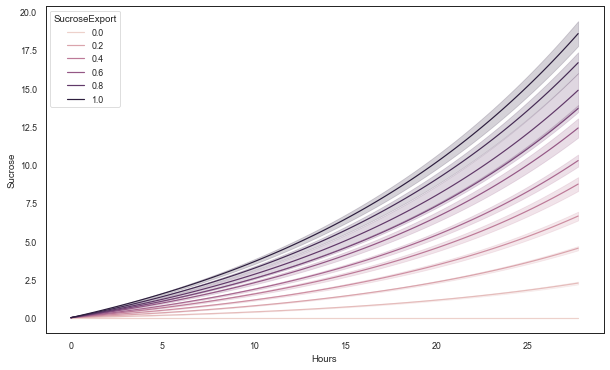

In [20]:
f, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='Hours',y='Sucrose',hue='SucroseExport',ci='sd',data=df,ax=ax)


<AxesSubplot:xlabel='Hours', ylabel='Sucrose'>

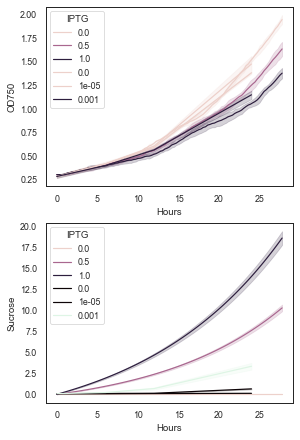

In [29]:
fig = plt.figure(constrained_layout=True, figsize=(7.5,6))
gs0 = gridspec.GridSpec(4, 2, figure=fig)
sns.set_context('paper')
sns.set_style('white')
ax2 = fig.add_subplot(gs0[2:, 0])
ax1 = fig.add_subplot(gs0[:2, 0],sharex=ax2)

sns.lineplot(x='Hours',y='OD750',hue='SucroseExport',ci='sd',data=df[(df.SucroseExport==0) | (df.SucroseExport==0.5) | (df.SucroseExport==1)],ax=ax1)
sns.lineplot(x='Hours',y='Sucrose',hue='SucroseExport',ci='sd',data=df[(df.SucroseExport==0) | (df.SucroseExport==0.5) | (df.SucroseExport==1)],ax=ax2)
sns.lineplot(x='Time',y='OD750',hue='IPTG',ci='sd',data=Experimental,ax=ax1)
sns.lineplot(x='Time',y='Sucrose_mM',hue='IPTG',ci='sd',data=Experimental,ax=ax2,palette='mako')


In [ ]:
types = ['D:/runs/axenic-cyanobacteria/Sucrose_%.1f/Results/ntypes.csv'%i for i in ExportRatio]
biomass = ['D:/runs/axenic-cyanobacteria/Sucrose_%.1f/Results/biomass.csv'%i for i in ExportRatio]
Cons = ['D:/runs/axenic-cyanobacteria/Sucrose_%.1f/Results/avg_concentration.csv'%i for i in ExportRatio]
ExpPath = 'C:/Users/Jonathan/OneDrive - Michigan State University/Analysis/sucrose and growth CSCB-SPS.xlsx'
OD = pd.read_excel(ExpPath,sheet_name='OD750')
Sucrose = pd.read_excel(ExpPath,sheet_name='suc')
Experimental.Time = Experimental.Time/24
#IPTG = pd.read_excel(ExpPath,sheet_name='+IPTG')
#IPTG.Time = IPTG.Time/24
SucroseMW = 342.3
O2MW = 32
CO2MW = 44.01
dens = 1e9
Volume = 1e-4*1e-4*1e-5 #m^3
CellNum2OD = Volume*1e6/0.3e-8
Biomass2OD = 1e12
tStep2Days = 10/3600/24
sucs = np.linspace(0,1,6)
pctC = 0.5
light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max = 0.047*24 #2.25e-05# 1/d
K_m_light = 3.5e-04
K_m_co2 = 5e-2
# y= mu_max
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

dfs = []
for ntype,con,bio,i,sucR in zip(types,Cons,biomass,range(1,len(Run_folders)+1),ExportRatio):
    #n_types
    df1 = pd.read_csv(ntype,usecols=[0,1],names=['Time','OD600'],skiprows=1,delimiter='	')

    df1.iloc[:,1] = df1.iloc[:,1]/CellNum2OD
    
    #avg_con
    df2 = pd.read_csv(con,usecols=[0,2,3,4],names=['Time','O2','Sucrose','CO2'],skiprows=1,delimiter='	')
    #df2.index = df2.index*tStep2Days
    #df2.index.name='Days'
    df2.O2 = df2.O2/O2MW*1e3
    df2.Sucrose = df2.Sucrose/SucroseMW*1e3
    df2['CO2'] = df2['CO2']/CO2MW*1e3
    
    # biomass
    df3 = pd.read_csv(bio,usecols=[0,1],names=['Time','Biomass'],skiprows=1,delimiter='	')
    #df3.index = df3.Time*tStep2Days*24
    df3.Biomass = df3.Biomass*Biomass2OD
    df2['SucroseVol'] = df2.Sucrose*Volume*1e18/df1.OD600
      
    reg = LinearRegression()
    reg.fit(df2[:10].index.values.reshape(-1, 1),df2[:10].SucroseVol)
    df2['Productivity'] = reg.coef_[0]/1e2
    CellMass = df3[df3.index <= 24].Biomass.iloc[-1]/Biomass2OD/Volume# - df.Biomass.iloc[0]

    SucMass = df2[df2.index <= 24].iloc[-1].Sucrose# - df2.Sucrose.iloc[0]
    TotalMass = CellMass + SucMass
    
    df = pd.concat([df1.iloc[:,1],df2,df3.iloc[:,1]],axis=1)
    df.Time = df.Time/60/60/24*10 #convert timesteps (10s) to days
    #df.index.name='Days'
    df['SucroseExport'] = sucR
    df['CellMass']= CellMass
    df['SucMass'] = SucMass
    df['TotalMass'] = TotalMass
    df['RelCell'] = CellMass/TotalMass
    df['RelSuc'] = SucMass/TotalMass
    df['Ratio'] = TotalMass/CellMass
    dfs.append(df)
df = pd.concat(dfs)

    #ax.plot(df.iloc[:,1],label=f'Sucrose Export {ExportRatio[i-1] :.2f}')


In [ ]:
df.CellMass.unique()

array([0.439674 , 0.4274656, 0.4155923, 0.4040451, 0.3928151, 0.3818937,
       0.3712725, 0.3609434, 0.3508983, 0.3411297, 0.33163  ])

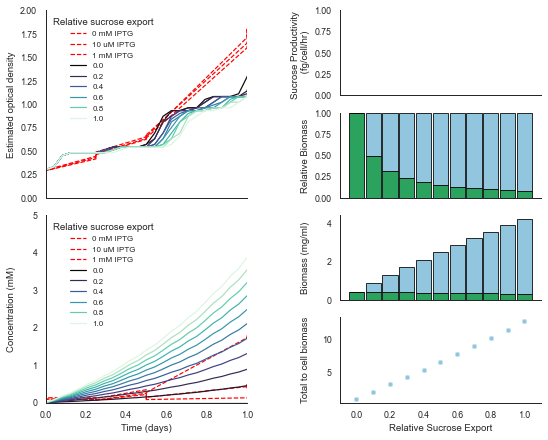

In [ ]:
#f,axes = plt.subplots(nrows=4,ncols=2,figsize=(12,15))
fig = plt.figure(constrained_layout=True, figsize=(7.5,6))
gs0 = gridspec.GridSpec(4, 2, figure=fig)
sns.set_context('paper')
sns.set_style('white')

ax2 = fig.add_subplot(gs0[2:, 0])
ax1 = fig.add_subplot(gs0[:2, 0],sharex=ax2)

ax6 = fig.add_subplot(gs0[3,1])
ax3 = fig.add_subplot(gs0[0,1],sharex=ax6)
ax4 = fig.add_subplot(gs0[1,1],sharex=ax6)
ax5 = fig.add_subplot(gs0[2,1],sharex=ax6)

iptg = [0,1e-5,1e-3]
labels = ['0 mM IPTG','10 uM IPTG','1 mM IPTG']
for induction,label in zip(iptg,labels):
    temp = Experimental[Experimental.IPTG==induction]
    ax1.plot(temp.Time,temp.OD750,label=label,c='red',ls='--')
#ax1.plot(IPTG.Time,IPTG.OD,label='+IPTG',c='grey',ls='--')
sns.lineplot(x='Time',y='OD600',hue='SucroseExport',data=df,ax=ax1,palette='mako')

for induction,label in zip(iptg,labels):
    temp = Experimental[Experimental.IPTG==induction]
    ax2.plot(temp.Time,temp.Sucrose/SucroseMW*1e3,label=label,c='red',ls='--')
#ax2.plot(Experimental.Time,Experimental.Sucrose,label='Control',c='red',ls='--')
#ax2.plot(IPTG.Time,IPTG.Sucrose,label='+IPTG',c='grey',ls='--')
sns.lineplot(x='Time',y='Sucrose',hue='SucroseExport',data=df,ax=ax2,palette='mako')
sns.despine()
ax2.set_xlabel('Time (days)')
ax1.set_ylabel(r'Estimated optical density')
ax2.set_ylabel('Concentration (mM)')
#ax1.set_xlim([0,2])
ax2.set_xlim([0,1])
ax1.set_ylim([0,2])
ax2.set_ylim([0,5])
ax1.legend(frameon=False,title='Relative sucrose export',fontsize='small')
ax2.legend(frameon=False,loc='upper left',title='Relative sucrose export',fontsize='small')

#sns.scatterplot(x='SucroseExport',y='Productivity',data=df,ax=ax3,color='#92c5de')
#sns.barplot(x='SucroseExport',y='CellMass',data=df,ax=axes[1,1])
width = 1/len(Run_folders)
ax4.bar(ExportRatio,df.RelCell.unique(),width,label='Cell Biomass',edgecolor='k',color='#2ca25f')
ax4.bar(ExportRatio,df.RelSuc.unique(),width,bottom=df.RelCell.unique(),label='Sucrose Biomass',edgecolor='k',color='#92c5de')

ax5.bar(ExportRatio,df.CellMass.unique(),width,label='Cell Biomass',edgecolor='k',color='#2ca25f')
ax5.bar(ExportRatio,df.SucMass.unique(),width,bottom=df.CellMass.unique(),label='Sucrose Biomass',edgecolor='k',color='#92c5de')
sns.scatterplot(x='SucroseExport',y='Ratio',data=df,ax=ax6,color='#92c5de')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
ax1.set_xlabel('')
ax3.set_xlabel('')
ax3.set_ylabel('Sucrose Productivity \n (fg/cell/hr)')
ax4.set_ylabel('Relative Biomass')
ax5.set_ylabel('Biomass (mg/ml)')
ax6.set_xlabel('Relative Sucrose Export')
ax6.set_ylabel('Total to cell biomass')
fig.align_ylabels()
#fig.savefig('validationSE.png',dpi=600)
#f.tight_layout()



<AxesSubplot:xlabel='IPTG', ylabel='OD750'>

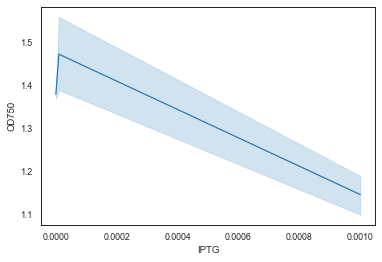

In [39]:
f, ax = plt.subplots()
sns.lineplot(x='IPTG',y='OD750',data=Experimental.loc[Experimental.Time==24],ax=ax)

<AxesSubplot:xlabel='IPTG', ylabel='Sucrose'>

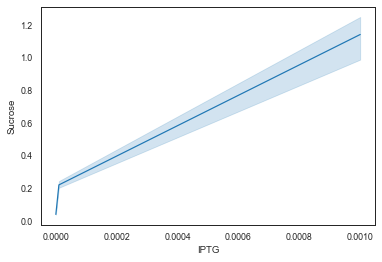

In [38]:
f, ax = plt.subplots()
sns.lineplot(x='IPTG',y='Sucrose',data=Experimental.loc[Experimental.Time==24],ax=ax)


In [55]:
Experimental.loc[Experimental.Time==24,'SucroseNorm'] = Experimental.loc[Experimental.Time==24,'Sucrose']/Experimental.loc[(Experimental.Time==24) & (Experimental.IPTG ==1e-3),'Sucrose'].mean()

In [49]:
Experimental.loc[Experimental.Time==24]

,Time,OD750,IPTG,Biomass,Sucrose,Total Biomass,% Sucrose,% Biomass,Biomass Ratio,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Sucrose_mM,SucroseNorm
9,24,1.37,0.00000,0.35158,0.041441,0.393021,0.105443,0.894557,0.117872,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121067,0.036309
10,24,1.39,0.00000,0.40211,0.040667,0.442777,0.091845,0.908155,0.101133,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.118804,0.035630
11,24,1.38,0.00000,0.37895,0.043508,0.422458,0.102989,0.897011,0.114813,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.127106,0.038120
21,24,1.56,0.00001,0.37263,0.245549,0.618179,0.397214,0.602786,0.658963,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.717352,0.215139
22,24,1.39,0.00001,0.41263,0.216502,0.629132,0.344128,0.655872,0.524688,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.632491,0.189688
23,24,1.47,0.00001,0.38316,0.204816,0.587976,0.348341,0.651659,0.534544,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598352,0.179450
33,24,1.15,0.00100,0.30316,1.248662,1.551822,0.804642,0.195358,4.118820,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.647857,1.094017
34,24,1.10,0.00100,0.36632,1.187468,1.553788,0.764241,0.235759,3.241614,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.469085,1.040402
35,24,1.19,0.00100,0.33053,0.987935,1.318465,0.749307,0.250693,2.988942,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.886167,0.865581


<AxesSubplot:xlabel='IPTG', ylabel='Sucrose'>

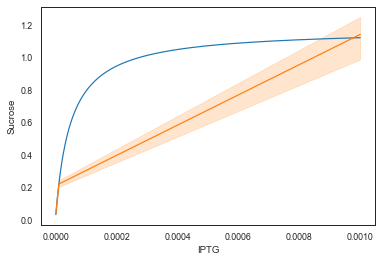

In [58]:
x = np.linspace(0,1e-3,1000)
k = 5e-5
mu = 1.67e-5
def func(x):
    return x/(k + x)+.03
f, ax = plt.subplots()
ax.plot(x,func(x)*Experimental.loc[(Experimental.Time==24) & (Experimental.IPTG ==1e-3),'Sucrose'].mean())

sns.lineplot(x='IPTG',y='Sucrose',data=Experimental.loc[Experimental.Time==24],ax=ax)

<AxesSubplot:xlabel='IPTG', ylabel='OD750'>

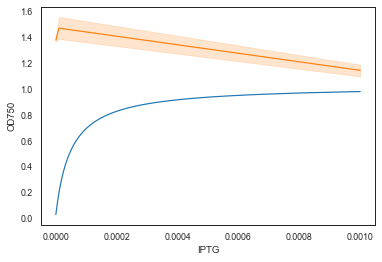

In [59]:
x = np.linspace(0,1e-3,1000)
k = 5e-5
mu = 1.67e-5
def func(x):
    return x/(k + x)+.03
f, ax = plt.subplots()
ax.plot(x,func(x))

sns.lineplot(x='IPTG',y='OD750',data=Experimental.loc[Experimental.Time==24],ax=ax)

In [60]:
Volume = 1e-4*1e-4*1e-4 #m^3
CellNum2OD = Volume*1e6/0.3e-8
100/CellNum2OD

0.30000000000000004

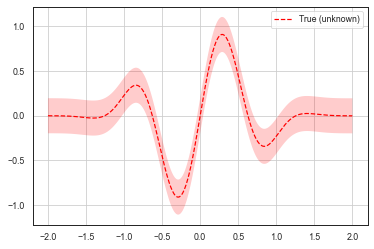

In [62]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [86]:
low_suc = df.loc[(df.Hours > 23.8) & (df.Hours < 24) & (df.SucroseExport==0)].mean()[['OD750','Sucrose']].to_numpy()
high_suc = df.loc[(df.Hours > 23.8) & (df.Hours < 24) & (df.SucroseExport==1)].mean()[['OD750','Sucrose']].to_numpy()
low_suc

array([1.50720000e+00, 2.91885357e-19])

In [87]:
exp_low = [1.38,.041872]
exp_high = [1.146667,1.141355]

In [92]:
np.sqrt((low_suc - exp_low)**2).sum() + np.sqrt((high_suc - exp_high)**2).sum()


13.014151585823894

In [95]:
# define an objective function
def objective(args):
    case, val = args
    if case == 'case 1':
        return val
    else:
        return val ** 2

# define a search space
from hyperopt import hp
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

print(best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print(space_eval(space, best))

100%|██████████| 100/100 [00:00<00:00, 245.71trial/s, best loss: 0.0001969022775426608]
{'a': 1, 'c2': -0.014032187197392316}
('case 2', -0.014032187197392316)


In [97]:
1 + hp.lognormal('c1', 0, 1)

In [99]:
from hyperopt import fmin, tpe, hp
best = fmin(fn=lambda x: x ** 2,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100)
print (best)

100%|██████████| 100/100 [00:00<00:00, 418.36trial/s, best loss: 0.0010249015755572515]
{'x': 0.03201408401871357}


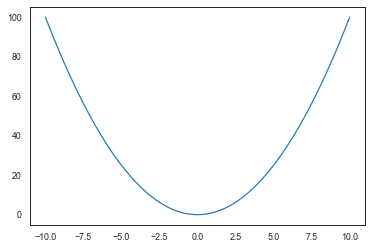

In [101]:
fn=lambda x: x ** 2
xs = np.linspace(-10,10)
plt.plot(xs,fn(xs))

In [104]:
x = np.linspace(-2, 2, 400).reshape(-1, 1)
x.shape

(400, 1)

In [106]:
[(0., 1.),] * 6

[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [110]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(x[1] * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

In [111]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

In [108]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0),(-5.0, 5.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

In [109]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.2617, f(x^*)=-1.0991'